In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

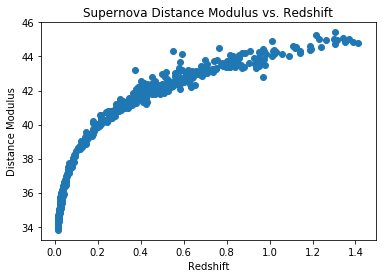

In [7]:
sn_data = pd.read_csv("./data.txt", sep="\t", header=0)
plt.scatter(sn_data["redshift"], sn_data["distance modulus"])
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift')
plt.show()


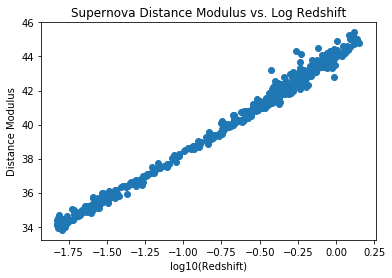

In [8]:
plt.scatter(np.log10(sn_data["redshift"]), sn_data["distance modulus"])
plt.xlabel('log10(Redshift)')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Log Redshift')
plt.show()

In [14]:
small_z_data = sn_data[sn_data["redshift"] < 0.05]
print(len(small_z_data))

140


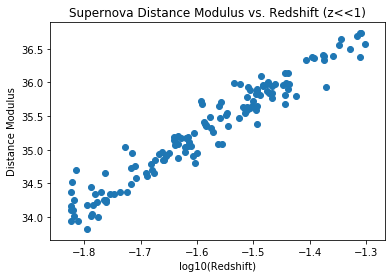

In [15]:
plt.scatter(np.log10(small_z_data["redshift"]), small_z_data["distance modulus"])
plt.xlabel('log10(Redshift)')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift (z<<1)')
plt.show()

In [16]:
H0_model = LinearRegression()
X = np.array(np.log10(small_z_data["redshift"])).reshape(-1, 1)
y = np.array(small_z_data["distance modulus"])

H0_model.fit(X, y)
H0_model.intercept_

43.26417969448623

In [17]:
H0 = 70 * 10**((H0_model.intercept_ - 43.17) / (-5.0))
H0

67.0289013579544